In [1]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import scipy.io as sio
import numpy as np
import warnings

In [11]:
def zero2Nan(arr):
    arr = np.where(arr==0, np.nan, arr)
    return arr

def compute_mean(arr, w=None):
    arr_sum = 0
    w_sum = 0
    (m, n, p) = np.shape(arr)
    if w is None:
        w = np.ones((m, n, p))
    for i in range(0,m):
        for j in range(0,n):
            for k in range(0,p):
                if not np.isnan(arr[i,j,k]):
                    w_sum = w_sum + w[i,j,k]
                    arr_sum = arr_sum + arr[i,j,k]*w[i,j,k]
    return arr_sum/w_sum

def visualize_average_profiles(KappaBG, ver='REG', log=True, show=True):
    kappa = KappaBG.createKappa(ver)
    weighted_means = KappaBG.getWeightedMeans(kappa)
    z_means = dict()
    vec = np.ones((50,1))
    fig = plt.figure(figsize=(8, 10))
    
    colors = plt.get_cmap('tab10')(np.arange(10, dtype=int))
    
    for i, k in enumerate(weighted_means.keys()):
        if k != 'basin':
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                z_means[k] = np.squeeze(np.nanmean(zero2Nan(kappa*KappaBG.reg_logic[k]), axis=(0,1)))
                plt.plot(z_means[k], KappaBG.mgrid['Depth'][0,0], color=colors[i], marker='o', label=k)
                plt.plot(weighted_means[k]*vec, KappaBG.mgrid['Depth'][0,0], color=colors[i], linestyle='-.')
    
    plt.ylabel('depth')
    plt.yscale('symlog')
    plt.xlabel(r'$\kappa_{bg}$')
    if log:
        plt.xscale('log')
    
    pos = plt.gca().get_position()
    plt.gca().set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    plt.gca().legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    
    plt.title(f'{ver} Background Diffusivity Average Profile')

    if show:
        plt.tight_layout()
        plt.show()
    else:
        plt.close()
    return fig
        
def visualize_distributions(KappaBG, ver='OBS', show=True):
    kappa = KappaBG.createKappa(ver)
    (m, n, p) = np.shape(kappa)
    fig, axes = plt.subplots(int(p/4), 4, figsize=(12, 3*int(p/4)))
    colors = plt.get_cmap('tab10')(np.arange(10, dtype=int))
    for i, depth in enumerate(KappaBG.mgrid['Depth'][0,0]):
        if i < 4*int(p/4):
            ax = axes[int(i/4), int(i%4)]
            k_pop = kappa[:,:,i]
            for j, key in enumerate(['CB', 'EB', 'shelf', 'slope']):
                msk = (np.isnan(k_pop) == False) & (KappaBG.reg_logic[key][:,:,i] == True)
                x = np.log10(k_pop[msk])
                if len(x) != 0: 
                    n_bin = int((np.max(x) - np.min(x))/0.2)+1
                    ax.hist(x, bins=n_bin, histtype='stepfilled', label=key, ec=colors[j], fc=np.append(colors[j][:-1], 0.3))
            ax.set_title(f'z = {np.abs(mgrid["zcell"][0,0][i][0]):.3}')
            ax.set_xlabel(r'$\kappa_{bg}$')
    
    axes[0,3].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

    st = plt.suptitle(f'{ver} Background Diffusivity Distribution by Depth')
    
    st.set_y(1)
    fig.subplots_adjust(top=0.85)
                
    if show:
        plt.tight_layout()
        plt.show()
    else:
        plt.close()
    return fig

def visualize_maps(KappaBG, ver='REG', show=True):
    kappa = KappaBG.createKappa(ver)
    (m, n, p) = np.shape(kappa)
    lons = KappaBG.mgrid['lon'][0,0]
    lats = KappaBG.mgrid['lat'][0,0]
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    fig, axes = plt.subplots(int(p/4), 4, figsize=(16, 3*int(p/4)), subplot_kw={'projection': ccrs.NorthPolarStereo()})
    for i, depth in enumerate(KappaBG.mgrid['Depth'][0,0]):
        if i < 4*int(p/4):
            ax = axes[int(i/4), int(i%4)]
            k_pop = kappa[:,:,i]
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ax.pcolormesh(lons, lats, np.log10(k_pop), transform=ccrs.PlateCarree())
            ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())
            ax.coastlines()
            ax.gridlines(lw=1, ls=':', draw_labels=True, rotate_labels=False, xlocs=np.linspace(-180, 180, 13), ylocs=[])
            ax.set_boundary(circle, transform=ax.transAxes)
            ax.set_title(f'z = {np.abs(mgrid["zcell"][0,0][i][0]):.3}')
            
    st = plt.suptitle(f'{ver} Background Diffusivity Arctic Map')
    
    st.set_y(1)
    fig.subplots_adjust(top=0.85)
            
    if show:
        plt.tight_layout()
        plt.show()
    else:
        plt.close()
    return fig

In [3]:
class Kappa_BG:
    def __init__(self, kappa_ITP, mgrid, reg_logic):
        self.kappa_ITP = kappa_ITP
        self.mgrid = mgrid
        self.reg_logic = reg_logic
        self.means = None
        self.weighted_means = None
        
    def getWeightedMeans(self, kappa_bg=None):
        if kappa_bg is None:
            if self.weighted_means is not None:
                return self.weighted_means
            else:
                kappa = self.kappa_ITP
        else:
            kappa = kappa_bg
        weights = mgrid['vol'][0,0]
        weighted_means = dict()
        weighted_means['ARC'] = compute_mean(zero2Nan(kappa*self.reg_logic['ARC']), w=weights)
        weighted_means['CB'] = compute_mean(zero2Nan(kappa*self.reg_logic['CB']), w=weights)
        weighted_means['EB'] = compute_mean(zero2Nan(kappa*self.reg_logic['EB']), w=weights)
        weighted_means['basin'] = compute_mean(zero2Nan(kappa*(self.reg_logic['CB'] + self.reg_logic['EB'])), w=weights)
        weighted_means['shelf'] = compute_mean(zero2Nan(kappa*self.reg_logic['shelf']), w=weights)
        weighted_means['slope'] = compute_mean(zero2Nan(kappa*self.reg_logic['slope']), w=weights)
        
        if kappa_bg is None:
            self.weighted_means = weighted_means
        return weighted_means
    
    def getMeans(self, kappa_bg=None):
        if kappa_bg is None:
            if self.means is not None:
                return self.means
            else:
                kappa = self.kappa_ITP
        else:
            kappa = kappa_bg
        means = dict()
        means['ARC'] = compute_mean(zero2Nan(kappa*self.reg_logic['ARC']))
        means['CB'] = compute_mean(zero2Nan(kappa*self.reg_logic['CB']))
        means['EB'] = compute_mean(zero2Nan(kappa*self.reg_logic['EB']))
        means['basin'] = compute_mean(zero2Nan(kappa*(self.reg_logic['CB'] + self.reg_logic['EB'])))
        means['shelf'] = compute_mean(zero2Nan(kappa*self.reg_logic['shelf']))
        means['slope'] = compute_mean(zero2Nan(kappa*self.reg_logic['slope']))
        
        if kappa_bg is None:
            self.means = means
        return means
            
        
    def createKappa(self, ver='CTL'):
        (m, n, p) = np.shape(self.kappa_ITP)
        kappa = np.zeros((m, n, p))
        ocnmsk = mgrid['ocnmsk'][0,0]
        weighted_means = self.getWeightedMeans()
        if ver == 'CTL':
            kappa += reg_logic['ARC']*weighted_means['ARC']
        elif ver == 'HI':
            kappa += reg_logic['ARC']*weighted_means['shelf']
        elif ver == 'LO':
            kappa += reg_logic['ARC']*weighted_means['basin']
        elif ver == 'REG':
            kappa += reg_logic['CB']*weighted_means['CB']
            kappa += reg_logic['EB']*weighted_means['EB']
            kappa += reg_logic['shelf']*weighted_means['shelf']
            kappa += reg_logic['slope']*weighted_means['slope']
        else:
            return self.kappa_ITP
        kappa += reg_logic['NAt']*6.6e-6
        kappa = zero2Nan(kappa)
        kappa[ocnmsk == 0] = np.nan
        if np.any(np.equal(ocnmsk > 0, np.isnan(kappa))):
            print('Error: there are ocean gridcells that do not contain a kappa value')
        return kappa

## Load MAT files as globals

In [4]:
kappa_ITP = sio.loadmat('kappa_ITP')['kappa']
mgrid = sio.loadmat('mgrid')['mgrid']
regional_logicals = sio.loadmat('regional_logicals')
reg_logic = dict()
for key in ['ARC', 'CB', 'EB', 'NAt', 'reg', 'shelf', 'slope']:
    reg_logic[key] = regional_logicals['ii_' + key]
    
KappaBG = Kappa_BG(kappa_ITP, mgrid, reg_logic)

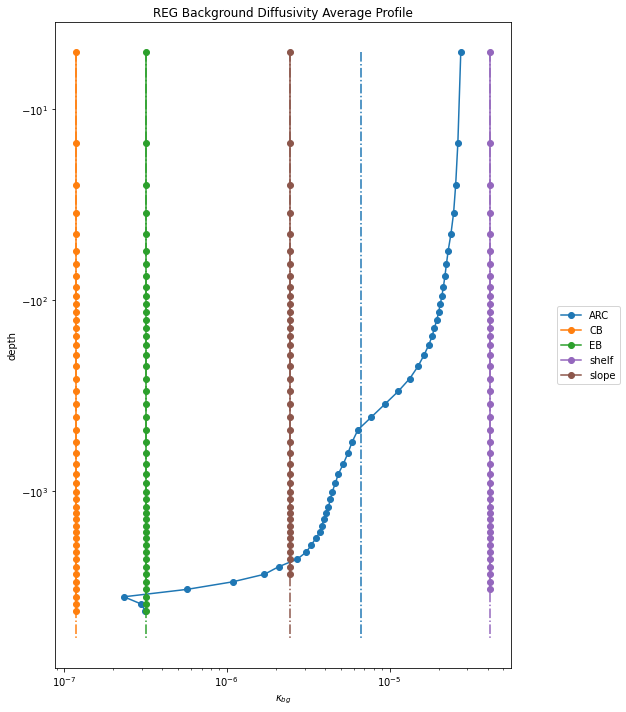

In [5]:
avg_prof = visualize_average_profiles(KappaBG, show=True)

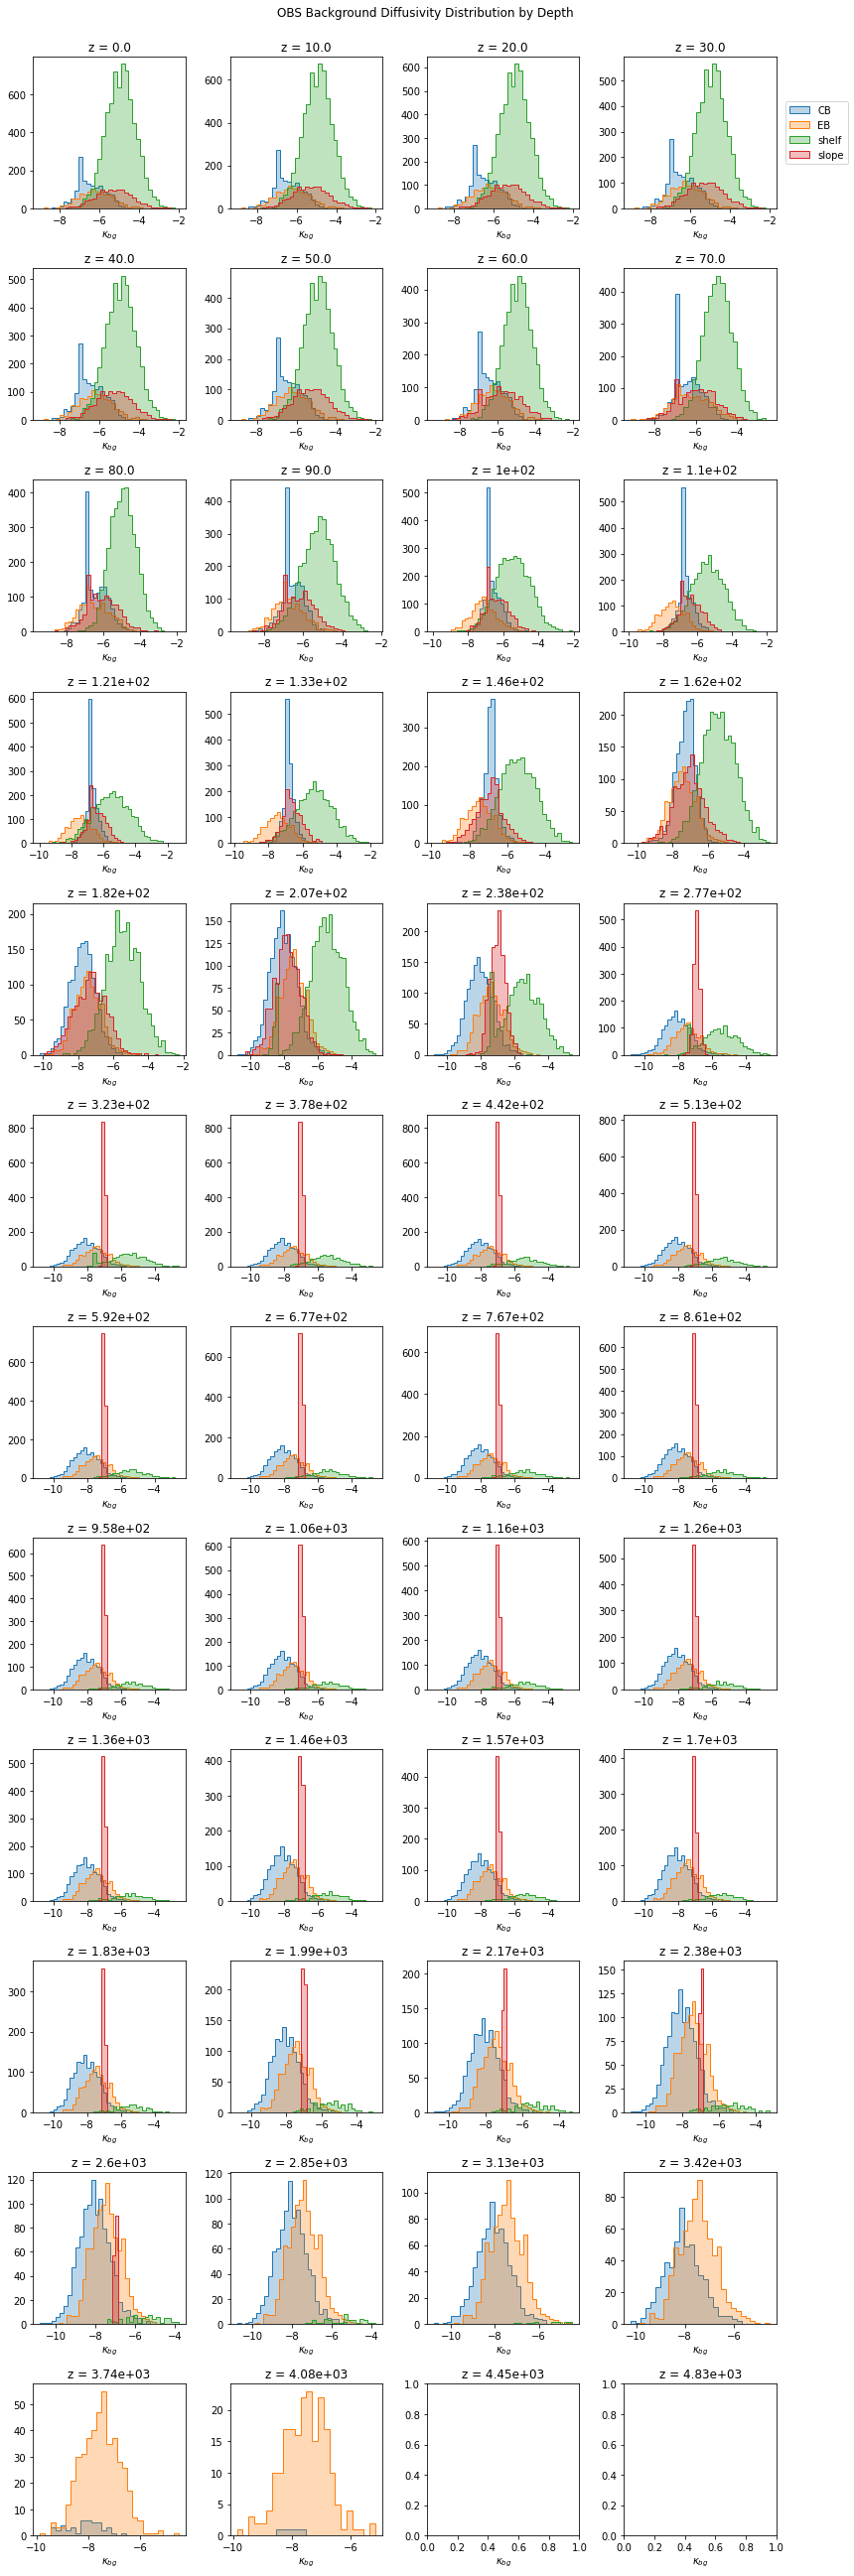

In [6]:
dist = visualize_distributions(KappaBG, show=True)

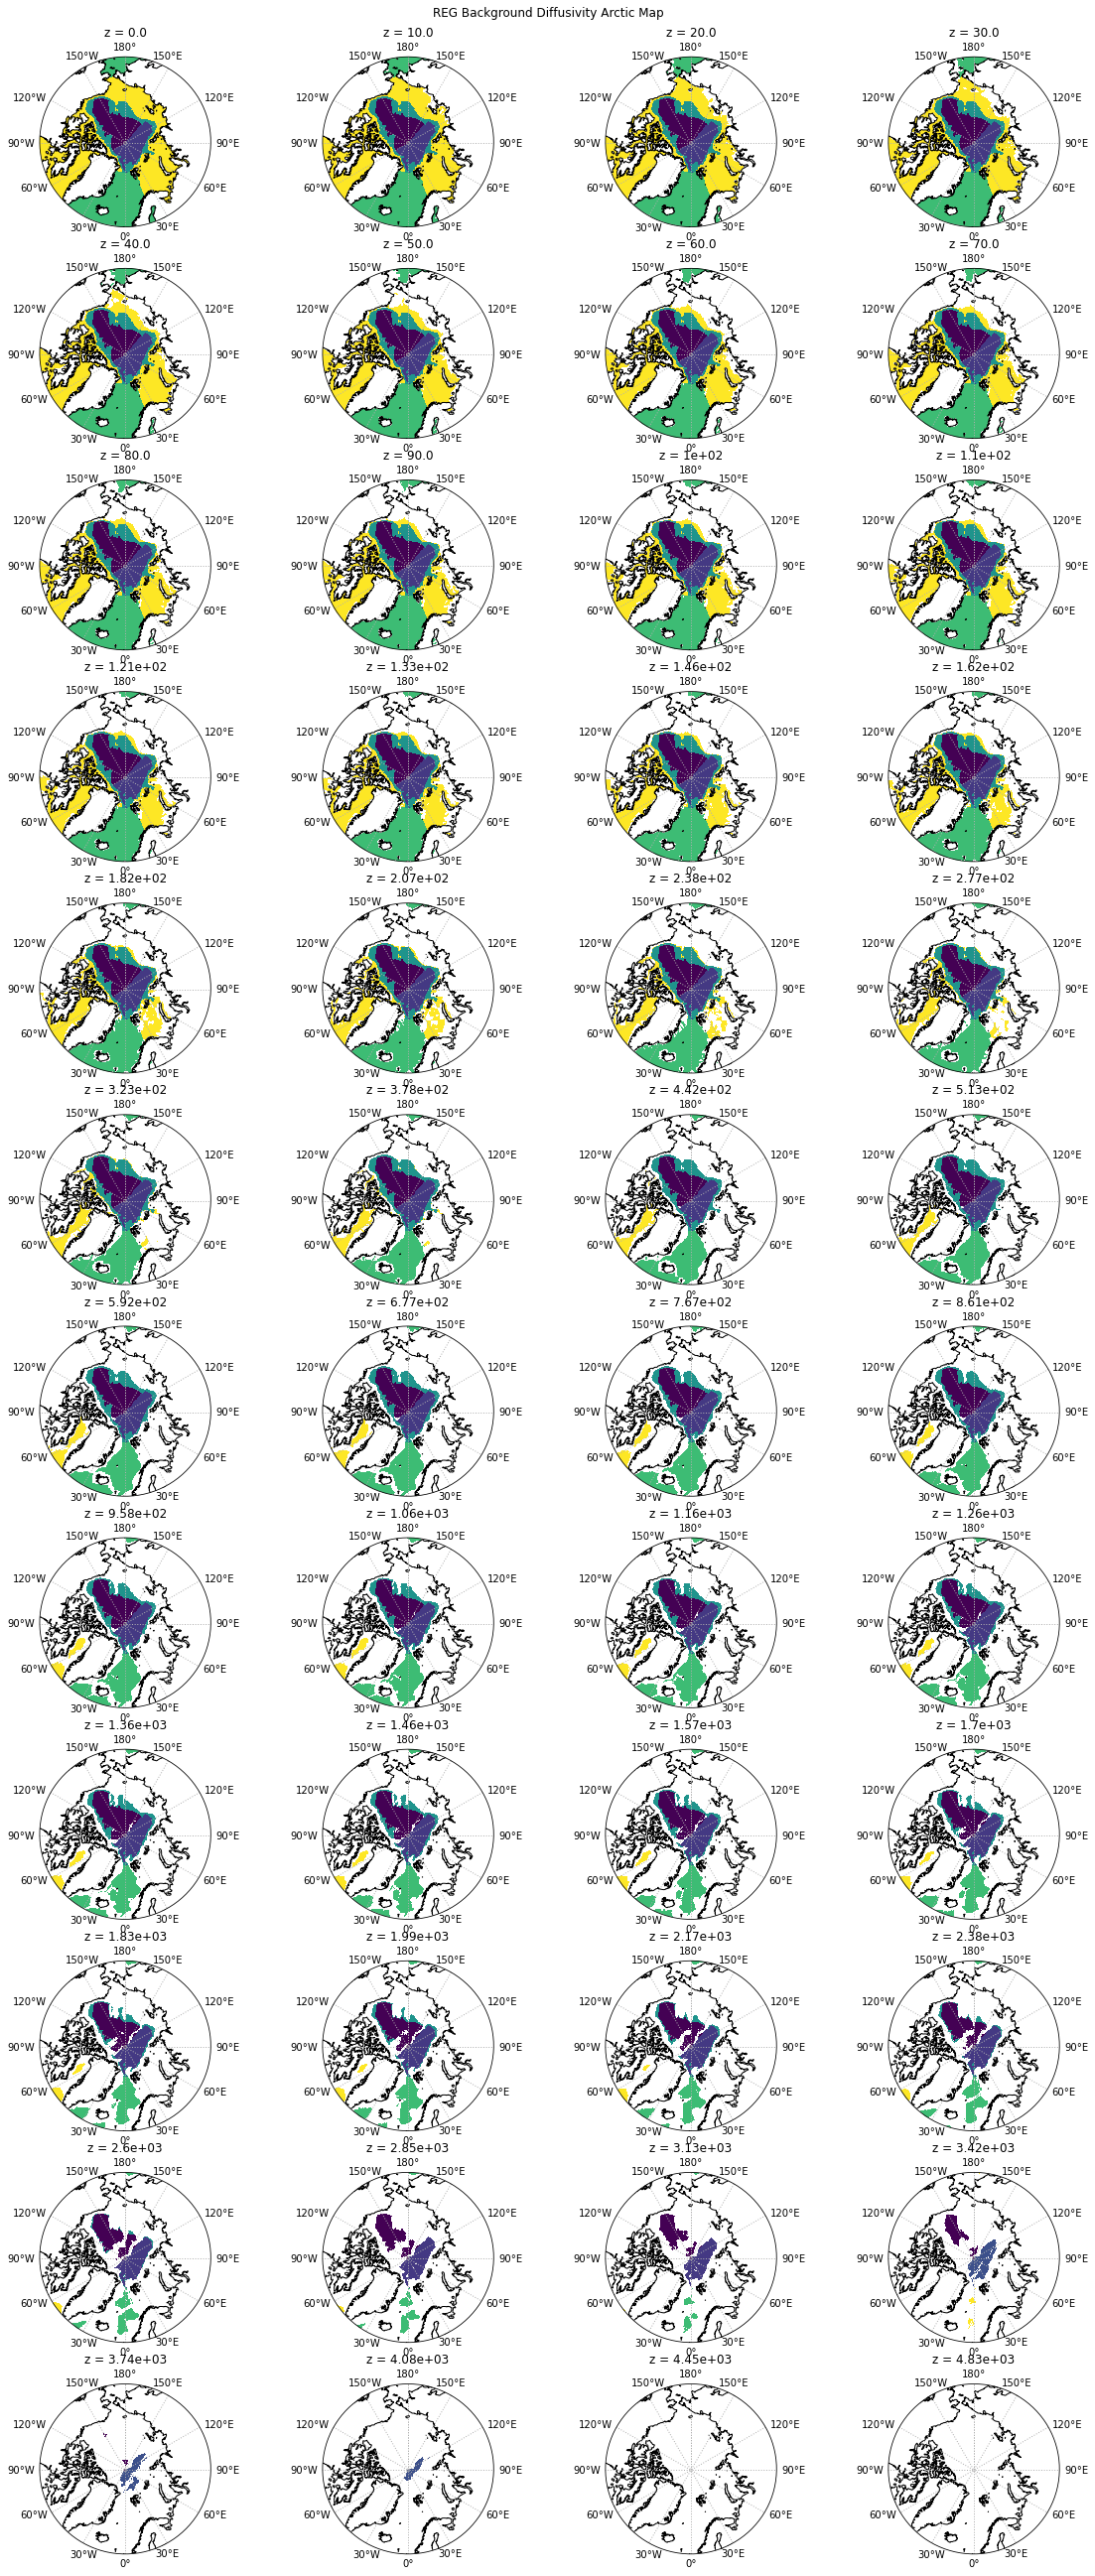

In [13]:
maps = visualize_maps(KappaBG, show=True)